In [1]:
import glob
import os
import pickle
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.ticker as tck
from matplotlib.gridspec import GridSpec

## Preprocess

In [2]:
def read_storge(rofdir, start_date, end_date, nlat, nlon, lats, lons):
    y1 = int(start_date[:4])
    y2 = int(end_date[:4])
    time = pd.date_range(
        str(y1) + "-01-01",
        str(y2) + "-12-31",
        freq="D",
    )
    leapday_idx = (time.month == 2) & (time.day == 29)
    time = time[~leapday_idx]
    list_store = []
    for year in range(y1, y2 + 1):
        # print('processing', year)
        qfile = rofdir + "storge%i.bin" % year
        if not os.path.isfile(qfile):
            print("doesn't exist", qfile)
            continue
        outflw = np.fromfile(qfile, "<f").reshape(-1, nlat, nlon)
        outflw[outflw > 1.0e19] = 0
        list_store.append(outflw)
    store = xr.DataArray(
        np.vstack(list_store),
        dims=("time", "lat", "lon"),
        coords={"time": time, "lat": lats, "lon": lons},
    )
    return store

def read_outflw(rofdir, start_date, end_date, nlat, nlon, lats, lons):
    y1 = int(start_date[:4])
    y2 = int(end_date[:4])
    time = pd.date_range(
        str(y1) + "-01-01",
        str(y2) + "-12-31",
        freq="D",
    )
    leapday_idx = (time.month == 2) & (time.day == 29)
    time = time[~leapday_idx]
    list_outflw = []
    for year in range(y1, y2 + 1):
        # print('processing', year)
        qfile = rofdir + "outflw%i.bin" % year
        if not os.path.isfile(qfile):
            print("doesn't exist", qfile)
            continue
        outflw = np.fromfile(qfile, "<f").reshape(-1, nlat, nlon)
        outflw[outflw > 1.0e19] = 0
        list_outflw.append(outflw)
    outflw = xr.DataArray(
        np.vstack(list_outflw),
        dims=("time", "lat", "lon"),
        coords={"time": time, "lat": lats, "lon": lons},
    )
    return outflw

def get_gridcell_stations(sel_daminfo, qsim_grid):
    tmp = {}
    for idx, row in sel_daminfo.iterrows():
        xi0, yj0 = row.drt_pxi0, row.drt_pyj0
        qsim_sti = qsim_grid.isel(lat=yj0, lon=xi0)
        qsim_sti = qsim_sti.reset_coords(("lat", "lon"), drop=True)
        tmp[str(idx)] = qsim_sti
    mdl = xr.Dataset(tmp)
    return mdl

def get_gridcell_reservoir(sel_daminfo, sim, res_extent):
    tmp = {}
    res_extent_grd = res_extent.stack(ngrd=("lat", "lon"))
    sim_grd = sim.stack(ngrd=("lat", "lon"))
    for idx, row in sel_daminfo.iterrows():
        ma = np.where(res_extent_grd == idx)[0]
        sim_res = sim_grd.isel(ngrd=ma).sum("ngrd")  # /1.223e3 # m3 to acre-ft
        tmp[str(idx)] = sim_res
    sim_store = xr.Dataset(tmp)
    return sim_store

In [3]:
camadir = "/glade/work/elkoukah/empirical/reservoirs/cama400/"

daminfo_file = camadir + "my_dams_setup/pxpy_qmax_my_dam_list.xlsx"
daminfo_cr = pd.read_excel(daminfo_file, index_col="ID")
daminfo_cr['huc2'] = 'CR'
daminfo_file = camadir + "my_dams_setup/pxpy_qmax_my_dam_list_ca.xlsx"
daminfo_ca = pd.read_excel(daminfo_file, index_col="ID")
daminfo_ca['huc2'] = 'CA'

daminfo = pd.concat([daminfo_cr,daminfo_ca])

df_resopus = pd.read_csv('/glade/work/elkoukah/inputs/obs/ResOpsUS/ResOpsUS/attributes/reservoir_attributes.csv')

damspecs_cr = pd.read_csv('/glade/derecho/scratch/elkoukah/inputs/CFD/CR4km-opt_1981-2020_203x269/spec/dam_info_istarf_final_irr_usgs.csv', index_col="ID")
damspecs_ca = pd.read_csv('/glade/derecho/scratch/elkoukah/inputs/CFD/CA4km-opt_1980-2022_201x227/spec/dam_info_istarf_final_irr_usgs.csv', index_col="ID")
damspecs = pd.concat([damspecs_cr, damspecs_ca])

In [4]:
ma = daminfo.reset_index()['ID'].isin(df_resopus['DAM_ID'])
daminfo_obs = daminfo[ma.values]

In [5]:
obsdir = '/glade/work/elkoukah/inputs/obs/ResOpsUS/ResOpsUS/time_series_all/'

obs_release = xr.Dataset()
obs_storage = xr.Dataset()

for damid in daminfo_obs.index:
    # print(damid)
    data = pd.read_csv(obsdir+f'ResOpsUS_{damid}.csv')
    time = data["date"].values.astype("datetime64[D]")
    da_s = xr.DataArray(data['storage'].values.astype(float), dims=("time"), coords={"time": time})
    da_r = xr.DataArray(data['outflow'].values.astype(float), dims=("time"), coords={"time": time})
    obs_release[str(damid)] = da_r
    obs_storage[str(damid)] = da_s

In [6]:
# Eval period
start_date = "1981-01-01"
end_date = "2020-12-31"

### wateruse on

In [7]:
# CR
res = 0.05
x0 = -115.75
x1 = -105.60
y0 = 30.0
y1 = 43.45
lats = np.arange(y0 + res / 2, y1, res)[::-1]
lons = np.arange(x0 + res / 2, x1, res)
nlat, nlon = lats.size, lons.size
res_extent_file = "/glade/derecho/scratch/elkoukah/inputs/CFD/CR4km-opt_1981-2020_203x269/bin/dam_reservoir_map/reservoir_extent_203x269.int"
res_extent = np.fromfile(res_extent_file, "i4")
res_extent_cr = xr.DataArray(res_extent.reshape(nlat, nlon),dims=("lat", "lon"),coords={"lat": lats, "lon": lons},)
sel_daminfo_cr =  daminfo_obs[daminfo_obs['huc2']=='CR']
archivedir = "/glade/derecho/scratch/elkoukah/archive/"

In [8]:
# opt-istarf-wateruse
caseid_dam = "CR_conus404_asmo_newsurfdata_fanrootingdepth.002"
rofdir_dam = archivedir + caseid_dam + "/rof/cuoptest6_istarf_DAM_irrUSGS_spin1y/"
outflw_istarf_optcu = read_outflw(rofdir_dam, start_date, end_date, nlat, nlon, lats, lons)
gridded_storage_istarf_optcu = read_storge(rofdir_dam, start_date, end_date, nlat, nlon, lats, lons)
cr_qmdl_istarf_optcu = get_gridcell_stations(sel_daminfo_cr, outflw_istarf_optcu)
cr_storage_istarf_optcu = get_gridcell_reservoir(sel_daminfo_cr, gridded_storage_istarf_optcu, res_extent_cr)

In [12]:
# opt-istarf-wateruse + exports
if False:
    caseid_dam = "CR_conus404_asmo_newsurfdata_fanrootingdepth.002"
    rofdir_dam = archivedir + caseid_dam + "/rof/opt_istarf_irrUSGS_USBRexpout_ImeanPMobs/"
    outflw_istarf_optcu = read_outflw(rofdir_dam, start_date, end_date, nlat, nlon, lats, lons)
    gridded_storage_istarf_optcu = read_storge(rofdir_dam, start_date, end_date, nlat, nlon, lats, lons)
    cr_qmdl_istarf_optcu = get_gridcell_stations(sel_daminfo_cr, outflw_istarf_optcu)
    cr_storage_istarf_optcu = get_gridcell_reservoir(sel_daminfo_cr, gridded_storage_istarf_optcu, res_extent_cr)

In [9]:
# CA
res = 0.05
x0 = -124.600
x1 = -114.550
y0 = 32.050
y1 = 43.400
lats = np.arange(y0 + res / 2, y1, res)[::-1]
lons = np.arange(x0 + res / 2, x1, res)
nlat, nlon = lats.size, lons.size
damdir = "/glade/derecho/scratch/elkoukah/inputs/CFD/"
res_extent_file = damdir+ "CA4km-opt_1980-2022_201x227/bin/dam_reservoir_map/reservoir_extent_201x227.int"
res_extent = np.fromfile(res_extent_file, "i4")
res_extent_ca = xr.DataArray(res_extent.reshape(nlat, nlon), dims=("lat", "lon"), coords={"lat": lats, "lon": lons})
sel_daminfo_ca =  daminfo_obs[daminfo_obs['huc2']=='CA']

In [10]:
# opt-istarf-wateruse
caseid_dam = "CA_conus404_newsurfdata_asmo.opt_002"
rofdir_dam = archivedir + caseid_dam + "/rof/DAM_istarf_cu/"
outflw_istarf_optcu = read_outflw(rofdir_dam, start_date, end_date, nlat, nlon, lats, lons)
gridded_storage_istarf_optcu = read_storge(rofdir_dam, start_date, end_date, nlat, nlon, lats, lons)
ca_qmdl_istarf_optcu = get_gridcell_stations(sel_daminfo_ca, outflw_istarf_optcu)
ca_storage_istarf_optcu = get_gridcell_reservoir(sel_daminfo_ca, gridded_storage_istarf_optcu, res_extent_ca)

In [11]:
# concat regions
tdelta = slice("1986-10-01", "2020-09-30")
qmdl_istarf_optcu = xr.merge([cr_qmdl_istarf_optcu, ca_qmdl_istarf_optcu]).sel(time=tdelta)
storage_istarf_optcu = xr.merge([cr_storage_istarf_optcu, ca_storage_istarf_optcu]).sel(time=tdelta)

In [12]:
def calc_mkge(x,y):
    r2 = np.mean((y-y.mean()).T*(x-x.mean()))/(y.std()*x.std())
    beta = y.mean()/x.mean()
    beta_p = (y.mean()-x.mean())/x.std()
    sigma = y.std()/x.std()
    mkge = 1 - np.sqrt(((r2-1)**2 + (sigma-1)**2 + beta_p**2))
    return mkge, r2, beta_p, sigma, beta
def sel_time(xx, yy):
    xx = xx.sel(time=yy.time).data
    yy = yy.data[~np.isnan(xx)]
    xx = xx[~np.isnan(xx)]
    return xx, yy

In [15]:
# Metrics
iterables = [['storage','release'],['mkge', 'r2', 'beta_p', 'sigma', 'beta']]
index = pd.MultiIndex.from_product(iterables, names=["variable", "metric"])
metrics_nat = pd.DataFrame(np.full((daminfo_obs.shape[0], 10), np.nan), columns=index, index=daminfo_obs.index)
metrics_ref = pd.DataFrame(np.full((daminfo_obs.shape[0], 10), np.nan), columns=index, index=daminfo_obs.index)
metrics_opt = pd.DataFrame(np.full((daminfo_obs.shape[0], 10), np.nan), columns=index, index=daminfo_obs.index)
metrics_generic_opt = pd.DataFrame(np.full((daminfo_obs.shape[0], 10), np.nan), columns=index, index=daminfo_obs.index)

for damid in daminfo_obs.index:
    xx = obs_release[str(damid)]
    yy = qmdl_istarf_optcu[str(damid)]
    xx, yyopt = sel_time(xx, yy)
    if xx.size>0:
        mkge, r2, beta_p, sigma, beta = calc_mkge(xx,yyopt)
        metrics_opt.loc[damid, 'release'] = [mkge, r2, beta_p, sigma, beta]

    xx = obs_storage[str(damid)]
    yy = storage_istarf_optcu[str(damid)]/10**6
    xx, yyopt = sel_time(xx, yy)
    if xx.size>0:
        mkge, r2, beta_p, sigma, beta = calc_mkge(xx,yyopt)
        metrics_opt.loc[damid, 'storage'] = [mkge, r2, beta_p, sigma, beta]

In [16]:
s = daminfo_obs['Total storage (FSL, Mm3)'].sort_values(ascending=False)
# x = s.cumsum()/116420.7
x = s.cumsum()/128105 # Grand total
m = x[x<=0.7].index
# metrics_ref.loc[m].describe()
metrics_opt.loc[m].describe()
# metrics_generic_opt.loc[m].describe()

variable    storage                                                release  \
metric         mkge         r2     beta_p      sigma       beta       mkge   
count     11.000000  11.000000  11.000000  11.000000  11.000000  11.000000   
mean       0.447978   0.762425  -0.148027   0.868058   0.967277   0.292981   
std        0.231538   0.142622   0.486087   0.163862   0.109166   0.331522   
min        0.057617   0.530829  -0.915550   0.584351   0.800203  -0.515037   
25%        0.291014   0.684345  -0.486550   0.761131   0.890970   0.232458   
50%        0.428647   0.822881  -0.259960   0.873626   0.985398   0.320803   
75%        0.669712   0.848228   0.207098   1.001403   1.058061   0.506098   
max        0.752665   0.901538   0.622600   1.106219   1.101973   0.624881   

variable                                              
metric           r2     beta_p      sigma       beta  
count     11.000000  11.000000  11.000000  11.000000  
mean       0.476118   0.254414   0.941437   1.026118  
std        0.225633   0.315437   0.363991   0.600799  
min       -0.084268  -0.079881   0.229150  -0.384764  
25%        0.459416   0.001219   0.814122   0.958387  
50%        0.541827   0.094033   0.959872   1.044616  
75%        0.595076   0.559197   1.127870   1.125562  
max        0.711858   0.724907   1.634201   2.262579

In [31]:
dict_istarf_optcu = {'data':{'qmdl_istarf_optcu':qmdl_istarf_optcu, 
                            'storage_istarf_optcu':storage_istarf_optcu},
                    'metrics':{'metrics_opt':metrics_opt}}
pickle.dump(dict_istarf_optcu, open('out/dict_istarf_optcu.pkl', 'wb'))

### wateruse off

In [17]:
# CR
res = 0.05
x0 = -115.75
x1 = -105.60
y0 = 30.0
y1 = 43.45
lats = np.arange(y0 + res / 2, y1, res)[::-1]
lons = np.arange(x0 + res / 2, x1, res)
nlat, nlon = lats.size, lons.size
res_extent_file = "/glade/derecho/scratch/elkoukah/inputs/CFD/CR4km-opt_1980-2022_203x269/bin/dam_reservoir_map/reservoir_extent_203x269.int"
res_extent = np.fromfile(res_extent_file, "i4")
res_extent_cr = xr.DataArray(res_extent.reshape(nlat, nlon),dims=("lat", "lon"),coords={"lat": lats, "lon": lons},)
sel_daminfo_cr =  daminfo_obs[daminfo_obs['huc2']=='CR']
archivedir = "/glade/derecho/scratch/elkoukah/archive/"

In [18]:
# ref-istarf-nouse
archivedir = "/glade/derecho/scratch/elkoukah/archive/"
caseid_dam = "CR_conus404_newsurfdata_default.002"
rofdir_dam = archivedir + caseid_dam + "/rof/ref_istarf_nouse/"
outflw_istarf_refcu = read_outflw(rofdir_dam, start_date, end_date, nlat, nlon, lats, lons)
gridded_storage_istarf_refcu = read_storge(rofdir_dam, start_date, end_date, nlat, nlon, lats, lons)
cr_qmdl_istarf_ref_nouse = get_gridcell_stations(sel_daminfo_cr, outflw_istarf_refcu)
cr_storage_istarf_ref_nouse = get_gridcell_reservoir(sel_daminfo_cr, gridded_storage_istarf_refcu, res_extent_cr)

In [19]:
# ref-generic-nouse
archivedir = "/glade/derecho/scratch/elkoukah/archive/"
caseid_dam = "CR_conus404_newsurfdata_default.002"
# rofdir_dam = archivedir + caseid_dam + "/rof/istarf_DAM_irrUSGS_cu/"
rofdir_dam = archivedir + caseid_dam + "/rof/ref_generic_nouse/"
outflw_istarf_refcu = read_outflw(rofdir_dam, start_date, end_date, nlat, nlon, lats, lons)
gridded_storage_istarf_refcu = read_storge(rofdir_dam, start_date, end_date, nlat, nlon, lats, lons)
cr_qmdl_generic_ref_nouse = get_gridcell_stations(sel_daminfo_cr, outflw_istarf_refcu)
cr_storage_generic_ref_nouse = get_gridcell_reservoir(sel_daminfo_cr, gridded_storage_istarf_refcu, res_extent_cr)

In [20]:
# opt-istarf-nosue
caseid_dam = "CR_conus404_asmo_newsurfdata_fanrootingdepth.002"
rofdir_dam = archivedir + caseid_dam + "/rof/opt_istarf_nouse/"
outflw_istarf_optcu = read_outflw(rofdir_dam, start_date, end_date, nlat, nlon, lats, lons)
gridded_storage_istarf_optcu = read_storge(rofdir_dam, start_date, end_date, nlat, nlon, lats, lons)
cr_qmdl_istarf_opt_nouse = get_gridcell_stations(sel_daminfo_cr, outflw_istarf_optcu)
cr_storage_istarf_opt_nouse = get_gridcell_reservoir(sel_daminfo_cr, gridded_storage_istarf_optcu, res_extent_cr)

In [21]:
# opt-generic-nouse
caseid_dam = "CR_conus404_asmo_newsurfdata_fanrootingdepth.002"
rofdir_dam = archivedir + caseid_dam + "/rof/opt_generic_nouse/"
outflw_generic_optcu = read_outflw(rofdir_dam, start_date, end_date, nlat, nlon, lats, lons)
gridded_storage_generic_optcu = read_storge(rofdir_dam, start_date, end_date, nlat, nlon, lats, lons)
cr_qmdl_generic_opt_nouse = get_gridcell_stations(sel_daminfo_cr, outflw_generic_optcu)
cr_storage_generic_opt_nouse = get_gridcell_reservoir(sel_daminfo_cr, gridded_storage_generic_optcu, res_extent_cr)

In [22]:
# CA
res = 0.05
x0 = -124.600
x1 = -114.550
y0 = 32.050
y1 = 43.400
lats = np.arange(y0 + res / 2, y1, res)[::-1]
lons = np.arange(x0 + res / 2, x1, res)
nlat, nlon = lats.size, lons.size
damdir = "/glade/derecho/scratch/elkoukah/inputs/CFD/"
res_extent_file = damdir+ "CA4km-opt_1980-2022_201x227/bin/dam_reservoir_map/reservoir_extent_201x227.int"
res_extent = np.fromfile(res_extent_file, "i4")
res_extent_ca = xr.DataArray(res_extent.reshape(nlat, nlon), dims=("lat", "lon"), coords={"lat": lats, "lon": lons})
sel_daminfo_ca =  daminfo_obs[daminfo_obs['huc2']=='CA']

In [23]:
# ref-istarf-nouse
archivedir = "/glade/derecho/scratch/elkoukah/archive/"
caseid_dam = "CA_conus404_asmo_newsurfdata_default.001"
rofdir_dam = archivedir + caseid_dam + "/rof/ref_istarf_nouse/"
outflw_istarf_refcu = read_outflw(rofdir_dam, start_date, end_date, nlat, nlon, lats, lons)
gridded_storage_istarf_refcu = read_storge(rofdir_dam, start_date, end_date, nlat, nlon, lats, lons)
ca_qmdl_istarf_ref_nouse = get_gridcell_stations(sel_daminfo_ca, outflw_istarf_refcu)
ca_storage_istarf_ref_nouse = get_gridcell_reservoir(sel_daminfo_ca, gridded_storage_istarf_refcu, res_extent_ca)

In [24]:
# ref-generic-nouse
archivedir = "/glade/derecho/scratch/elkoukah/archive/"
caseid_dam = "CA_conus404_asmo_newsurfdata_default.001"
rofdir_dam = archivedir + caseid_dam + "/rof/ref_generic_nouse/"
outflw_istarf_refcu = read_outflw(rofdir_dam, start_date, end_date, nlat, nlon, lats, lons)
gridded_storage_istarf_refcu = read_storge(rofdir_dam, start_date, end_date, nlat, nlon, lats, lons)
ca_qmdl_generic_ref_nouse = get_gridcell_stations(sel_daminfo_ca, outflw_istarf_refcu)
ca_storage_generic_ref_nouse = get_gridcell_reservoir(sel_daminfo_ca, gridded_storage_istarf_refcu, res_extent_ca)

In [25]:
# opt-istarf-nouse
caseid_dam = "CA_conus404_newsurfdata_asmo.opt_002"
rofdir_dam = archivedir + caseid_dam + "/rof/opt_istarf_nouse/"
outflw_istarf_optcu = read_outflw(rofdir_dam, start_date, end_date, nlat, nlon, lats, lons)
gridded_storage_istarf_optcu = read_storge(rofdir_dam, start_date, end_date, nlat, nlon, lats, lons)
ca_qmdl_istarf_opt_nouse = get_gridcell_stations(sel_daminfo_ca, outflw_istarf_optcu)
ca_storage_istarf_opt_nouse = get_gridcell_reservoir(sel_daminfo_ca, gridded_storage_istarf_optcu, res_extent_ca)

In [26]:
# opt-generic-nouse
caseid_dam = "CA_conus404_newsurfdata_asmo.opt_002"
rofdir_dam = archivedir + caseid_dam + "/rof/opt_generic_nouse/"
outflw_generic_optcu = read_outflw(rofdir_dam, start_date, end_date, nlat, nlon, lats, lons)
gridded_storage_generic_optcu = read_storge(rofdir_dam, start_date, end_date, nlat, nlon, lats, lons)
ca_qmdl_generic_opt_nouse = get_gridcell_stations(sel_daminfo_ca, outflw_generic_optcu)
ca_storage_generic_opt_nouse = get_gridcell_reservoir(sel_daminfo_ca, gridded_storage_generic_optcu, res_extent_ca)

In [27]:
tdelta = slice("1986-10-01", "2020-09-30")

qmdl_istarf_ref_nouse = xr.merge([cr_qmdl_istarf_ref_nouse, ca_qmdl_istarf_ref_nouse]).sel(time=tdelta)
qmdl_istarf_opt_nouse = xr.merge([cr_qmdl_istarf_opt_nouse, ca_qmdl_istarf_opt_nouse]).sel(time=tdelta)

qmdl_generic_ref_nouse = xr.merge([cr_qmdl_generic_ref_nouse, ca_qmdl_generic_ref_nouse]).sel(time=tdelta)
qmdl_generic_opt_nouse = xr.merge([cr_qmdl_generic_opt_nouse, ca_qmdl_generic_opt_nouse]).sel(time=tdelta)

storage_istarf_ref_nouse = xr.merge([cr_storage_istarf_ref_nouse, ca_storage_istarf_ref_nouse]).sel(time=tdelta)
storage_istarf_opt_nouse = xr.merge([cr_storage_istarf_opt_nouse, ca_storage_istarf_opt_nouse]).sel(time=tdelta)

storage_generic_ref_nouse = xr.merge([cr_storage_generic_ref_nouse, ca_storage_generic_ref_nouse]).sel(time=tdelta)
storage_generic_opt_nouse = xr.merge([cr_storage_generic_opt_nouse, ca_storage_generic_opt_nouse]).sel(time=tdelta)

In [28]:
# Metrics
def calc_mkge(x,y):
    r2 = np.mean((y-y.mean()).T*(x-x.mean()))/(y.std()*x.std())
    beta = y.mean()/x.mean()
    beta_p = (y.mean()-x.mean())/x.std()
    sigma = y.std()/x.std()
    mkge = 1 - np.sqrt(((r2-1)**2 + (sigma-1)**2 + beta_p**2))
    return mkge, r2, beta_p, sigma, beta
def sel_time(xx, yy):
    xx = xx.resample(time='1M').mean()
    yy = yy.resample(time='1M').mean()
    xx = xx.sel(time=yy.time).data
    yy = yy.data[~np.isnan(xx)]
    xx = xx[~np.isnan(xx)]
    return xx, yy

# 
iterables = [['storage','release'],['mkge', 'r2', 'beta_p', 'sigma', 'beta']]
index = pd.MultiIndex.from_product(iterables, names=["variable", "metric"])
metrics_istarf_ref_nouse = pd.DataFrame(np.full((daminfo_obs.shape[0], 10), np.nan), columns=index, index=daminfo_obs.index)
metrics_istarf_opt_nouse = pd.DataFrame(np.full((daminfo_obs.shape[0], 10), np.nan), columns=index, index=daminfo_obs.index)
metrics_generic_ref_nouse = pd.DataFrame(np.full((daminfo_obs.shape[0], 10), np.nan), columns=index, index=daminfo_obs.index)
metrics_generic_opt_nouse = pd.DataFrame(np.full((daminfo_obs.shape[0], 10), np.nan), columns=index, index=daminfo_obs.index)

for damid in daminfo_obs.index:
    xx = obs_release[str(damid)]
    yy = qmdl_istarf_ref_nouse[str(damid)]
    xx, yyrefp = sel_time(xx, yy)
    xx = obs_release[str(damid)]
    yy = qmdl_istarf_opt_nouse[str(damid)]
    xx, yyoptp = sel_time(xx, yy)

    xx = obs_release[str(damid)]
    yy = qmdl_generic_ref_nouse[str(damid)]
    xx, yyrefg = sel_time(xx, yy)
    xx = obs_release[str(damid)]
    yy = qmdl_generic_opt_nouse[str(damid)]
    xx, yyoptg = sel_time(xx, yy)

    if xx.size>0:
        mkge, r2, beta_p, sigma, beta = calc_mkge(xx,yyrefp)
        metrics_istarf_ref_nouse.loc[damid, 'release'] = [mkge, r2, beta_p, sigma, beta]
        mkge, r2, beta_p, sigma, beta = calc_mkge(xx,yyoptp)
        metrics_istarf_opt_nouse.loc[damid, 'release'] = [mkge, r2, beta_p, sigma, beta]

        mkge, r2, beta_p, sigma, beta = calc_mkge(xx,yyrefg)
        metrics_generic_ref_nouse.loc[damid, 'release'] = [mkge, r2, beta_p, sigma, beta]
        mkge, r2, beta_p, sigma, beta = calc_mkge(xx,yyoptg)
        metrics_generic_opt_nouse.loc[damid, 'release'] = [mkge, r2, beta_p, sigma, beta]

    xx = obs_storage[str(damid)]
    yy = storage_istarf_ref_nouse[str(damid)]/10**6
    xx, yyrefp = sel_time(xx, yy)
    xx = obs_storage[str(damid)]
    yy = storage_istarf_opt_nouse[str(damid)]/10**6
    xx, yyoptp = sel_time(xx, yy)

    xx = obs_storage[str(damid)]
    yy = storage_generic_ref_nouse[str(damid)]/10**6
    xx, yyrefg = sel_time(xx, yy)
    xx = obs_storage[str(damid)]
    yy = storage_generic_opt_nouse[str(damid)]/10**6
    xx, yyoptg = sel_time(xx, yy)

    if xx.size>0:
        mkge, r2, beta_p, sigma, beta = calc_mkge(xx,yyrefp)
        metrics_istarf_ref_nouse.loc[damid, 'storage'] = [mkge, r2, beta_p, sigma, beta]
        mkge, r2, beta_p, sigma, beta = calc_mkge(xx,yyoptp)
        metrics_istarf_opt_nouse.loc[damid, 'storage'] = [mkge, r2, beta_p, sigma, beta]

        mkge, r2, beta_p, sigma, beta = calc_mkge(xx,yyrefg)
        metrics_generic_ref_nouse.loc[damid, 'storage'] = [mkge, r2, beta_p, sigma, beta]
        mkge, r2, beta_p, sigma, beta = calc_mkge(xx,yyoptg)
        metrics_generic_opt_nouse.loc[damid, 'storage'] = [mkge, r2, beta_p, sigma, beta]

In [ ]:
metrics_istarf_ref_nouse = pd.DataFrame(np.full((daminfo_obs.shape[0], 10), np.nan), columns=index, index=daminfo_obs.index)
metrics_istarf_opt_nouse = pd.DataFrame(np.full((daminfo_obs.shape[0], 10), np.nan), columns=index, index=daminfo_obs.index)
metrics_generic_ref_nouse = pd.DataFrame(np.full((daminfo_obs.shape[0], 10), np.nan), columns=index, index=daminfo_obs.index)
metrics_generic_opt_nouse = pd.DataFrame(np.full((daminfo_obs.shape[0], 10), np.nan), columns=index, index=daminfo_obs.index)

In [33]:
dict_istarf_generic_optref_nouse = {'data':{'qmdl_istarf_ref_nouse':qmdl_istarf_ref_nouse,
                            'qmdl_istarf_opt_nouse':qmdl_istarf_opt_nouse,
                            'qmdl_generic_ref_nouse':qmdl_generic_ref_nouse,
                            'qmdl_generic_opt_nouse':qmdl_generic_opt_nouse,
                            'storage_istarf_ref_nouse':storage_istarf_ref_nouse,
                            'storage_istarf_opt_nouse':storage_istarf_opt_nouse,
                            'storage_generic_ref_nouse':storage_generic_ref_nouse,
                            'storage_generic_opt_nouse':storage_generic_opt_nouse},
                    'metrics':{'metrics_istarf_ref_nouse':metrics_istarf_ref_nouse,
                               'metrics_istarf_opt_nouse':metrics_istarf_opt_nouse,
                               'metrics_generic_ref_nouse':metrics_generic_ref_nouse,
                               'metrics_generic_opt_nouse':metrics_generic_opt_nouse}}
pickle.dump(dict_istarf_generic_optref_nouse, open('out/dict_istarf_generic_optref_nouse.pkl', 'wb'))

In [68]:
# Timeseries

In [69]:
plot_tdelta = slice('1981-10-01', '2020-09-30')

qmdl_istarf_optcu = xr.merge([cr_qmdl_istarf_optcu, ca_qmdl_istarf_optcu]).sel(time=plot_tdelta)
storage_istarf_optcu = xr.merge([cr_storage_istarf_optcu, ca_storage_istarf_optcu]).sel(time=plot_tdelta)

obs_storage_t = obs_storage.sel(time=plot_tdelta)
obs_release_t = obs_release.sel(time=plot_tdelta)

In [70]:
qmdl_istarf_ref_nouse = xr.merge([cr_qmdl_istarf_ref_nouse, ca_qmdl_istarf_ref_nouse]).sel(time=plot_tdelta)
qmdl_istarf_opt_nouse = xr.merge([cr_qmdl_istarf_opt_nouse, ca_qmdl_istarf_opt_nouse]).sel(time=plot_tdelta)

qmdl_generic_ref_nouse = xr.merge([cr_qmdl_generic_ref_nouse, ca_qmdl_generic_ref_nouse]).sel(time=plot_tdelta)
qmdl_generic_opt_nouse = xr.merge([cr_qmdl_generic_opt_nouse, ca_qmdl_generic_opt_nouse]).sel(time=plot_tdelta)

storage_istarf_ref_nouse = xr.merge([cr_storage_istarf_ref_nouse, ca_storage_istarf_ref_nouse]).sel(time=plot_tdelta)
storage_istarf_opt_nouse = xr.merge([cr_storage_istarf_opt_nouse, ca_storage_istarf_opt_nouse]).sel(time=plot_tdelta)

storage_generic_ref_nouse = xr.merge([cr_storage_generic_ref_nouse, ca_storage_generic_ref_nouse]).sel(time=plot_tdelta)
storage_generic_opt_nouse = xr.merge([cr_storage_generic_opt_nouse, ca_storage_generic_opt_nouse]).sel(time=plot_tdelta)

In [71]:
dict_istarf_generic_timeseries = {'data':{'qmdl_istarf_optcu':qmdl_istarf_optcu,
                            'storage_istarf_optcu':storage_istarf_optcu,
                            'qmdl_istarf_ref_nouse':qmdl_istarf_ref_nouse,
                            'qmdl_istarf_opt_nouse':qmdl_istarf_opt_nouse,
                            'qmdl_generic_ref_nouse':qmdl_generic_ref_nouse,
                            'qmdl_generic_opt_nouse':qmdl_generic_opt_nouse,
                            'storage_istarf_ref_nouse':storage_istarf_ref_nouse,
                            'storage_istarf_opt_nouse':storage_istarf_opt_nouse,
                            'storage_generic_ref_nouse':storage_generic_ref_nouse,
                            'storage_generic_opt_nouse':storage_generic_opt_nouse},
                                 'obs':{'obs_storage_t':obs_storage_t, 'obs_release_t':obs_release_t}}
pickle.dump(dict_istarf_generic_timeseries, open('out/dict_istarf_generic_timeseries.pkl', 'wb'))

# Visualize

In [38]:
import matplotlib.gridspec as gridspec

In [35]:
v, m = 'storage','mkge'
print(v,m)
print('emp-ref', round(metrics_istarf_ref_nouse.loc[:, (v,m)].median(),2))
print('emp-opt', round(metrics_istarf_opt_nouse.loc[:, (v,m)].median(),2))
print('gen-ref', round(metrics_generic_ref_nouse.loc[:, (v,m)].median(),2))
print('gen-opt', round(metrics_generic_opt_nouse.loc[:, (v,m)].median(),2))

storage mkge
emp-ref 0.0
emp-opt 0.15
gen-ref -0.62
gen-opt -0.23


In [36]:
# nouse boxplot

In [37]:
istarfdf = pd.read_csv('/glade/work/elkoukah/inputs/reservoirs/ISTARF-CONUS/ISTARF-CONUS.csv') 
istarfdf_obs = istarfdf[istarfdf['GRanD_ID'].isin(daminfo_obs.index)]
damids_full = istarfdf_obs[istarfdf_obs['fit']=='full']['GRanD_ID']

In [50]:
list_data = []
for var in ('storage', 'release'):
    dict_data = {}
    for m in ('mkge','r2','sigma','beta_p'):
        s0 = metrics_istarf_ref_nouse.loc[damids_full][var,m].dropna()
        s1 = metrics_istarf_opt_nouse.loc[damids_full][var,m].dropna()
        r0 = metrics_generic_ref_nouse.loc[damids_full][var,m].dropna()
        r1 = metrics_generic_opt_nouse.loc[damids_full][var,m].dropna()
        dict_data[m] = ((s0,s1),(r0,r1))
    list_data.append(dict_data)

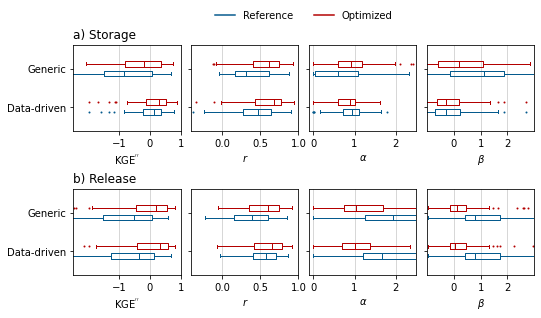

In [65]:
ylims = [(-2.5,1.), (-.4,1), (-0.1,2.5), (-1,3)]
ylabels = [r"KGE$^{''}$", r"$r$", r"$\alpha$", r"$\beta$"]
yticks = [[-1,0,1],[0,.5,1],[0,1,2],[0,1,2]]
colors = ['#045a8d','#b30000']

fig = plt.figure(figsize=(8,4))
gs1 = gridspec.GridSpec(1,4)
gs1.update(left=0.1,right=0.9,top=0.9,bottom=0.6,wspace=0.1,hspace=0.25)

dict_data = list_data[0] # storage
for i,m in enumerate(('mkge','r2','sigma','beta_p')):
    ax = plt.subplot(gs1[0,i])
    for ii in range(2):
        c = colors[ii]
        boxprops = dict(linestyle='-', linewidth=1, color=c)
        capprops = boxprops
        whiskerprops = boxprops
        flierprops = dict(marker='o', markerfacecolor=c, markersize=2,markeredgecolor='none')
        medianprops = dict(linestyle='-', linewidth=1, color=c)
        ax.boxplot(dict_data[m][0][ii], flierprops=flierprops, 
                          medianprops=medianprops, boxprops=boxprops,
                          whiskerprops=whiskerprops, capprops=capprops,
                          positions=[1+(ii*.25)], vert=False)
        ax.boxplot(dict_data[m][1][ii], flierprops=flierprops, 
                      medianprops=medianprops, boxprops=boxprops,
                      whiskerprops=whiskerprops, capprops=capprops,
                      positions=[2+(ii*.25)], vert=False)
    ax.set_xlim(ylims[i])
    ax.set_xlabel(ylabels[i])
    ax.set_yticks([1.125,2.125])
    if i==0:
        ax.set_yticklabels(['Data-driven', 'Generic'])
        ax.set_title('a) Storage', loc='left')
    else:
        ax.set_yticklabels(['', ''])
    ax.set_xticks(yticks[i])
    ax.grid(lw=.5,axis='x')



gs2 = gridspec.GridSpec(1,4)
gs2.update(left=0.1,right=0.9,top=0.4,bottom=0.1,wspace=0.1,hspace=0.25)

dict_data = list_data[1] # release
for i,m in enumerate(('mkge','r2','sigma','beta_p')):
    ax = plt.subplot(gs2[0,i])
    for ii in range(2):
        c = colors[ii]
        boxprops = dict(linestyle='-', linewidth=1, color=c)
        capprops = boxprops
        whiskerprops = boxprops
        flierprops = dict(marker='o', markerfacecolor=c, markersize=2,markeredgecolor='none')
        medianprops = dict(linestyle='-', linewidth=1, color=c)
        ax.boxplot(dict_data[m][0][ii], flierprops=flierprops, 
                          medianprops=medianprops, boxprops=boxprops,
                          whiskerprops=whiskerprops, capprops=capprops,
                          positions=[1+(ii*.25)], vert=False)
        ax.boxplot(dict_data[m][1][ii], flierprops=flierprops, 
                      medianprops=medianprops, boxprops=boxprops,
                      whiskerprops=whiskerprops, capprops=capprops,
                      positions=[2+(ii*.25)], vert=False)
    ax.set_xlim(ylims[i])
    ax.set_xlabel(ylabels[i])
    ax.set_yticks([1.125,2.125])
    if i==0:
        ax.set_yticklabels(['Data-driven', 'Generic'])
        ax.set_title('b) Release', loc='left')
    else:
        ax.set_yticklabels(['', ''])
    ax.set_xticks(yticks[i])
    ax.grid(lw=.5,axis='x')

plt.plot([],[],c=colors[0],label='Reference')
plt.plot([],[],c=colors[1],label='Optimized')
fig.legend(loc='upper center', bbox_to_anchor=(.5,1.05), ncol=2, frameon=False)

In [67]:
fig.savefig('figs/dam_sim_kge_boxplot_v01.png', dpi=300, bbox_inches='tight')

In [116]:
from statsmodels.stats.weightstats import ttest_ind

In [185]:
# t-tests 
var = 'storage'
m = 'mkge'
x = metrics_istarf_opt_nouse[var,m].dropna()
y = metrics_generic_opt_nouse[var,m].dropna()
# x = metrics_generic_ref_nouse[var,m].dropna()
ttest_ind(x, y, alternative='two-sided', usevar='pooled', weights=(None, None), value=0)

(0.6157229499051811, 0.5386287170800772, 254.0)

In [204]:
# t-tests 
var = 'storage'
m = 'mkge'
x = metrics_istarf_opt_nouse.loc[damids_full][var,m].dropna()
y = metrics_generic_opt_nouse.loc[damids_full][var,m].dropna()
ttest_ind(x, y, alternative='two-sided', usevar='pooled', weights=(None, None), value=0)

(2.4129255227737247, 0.017118997568613945, 140.0)

In [72]:
# Timeseries: one column

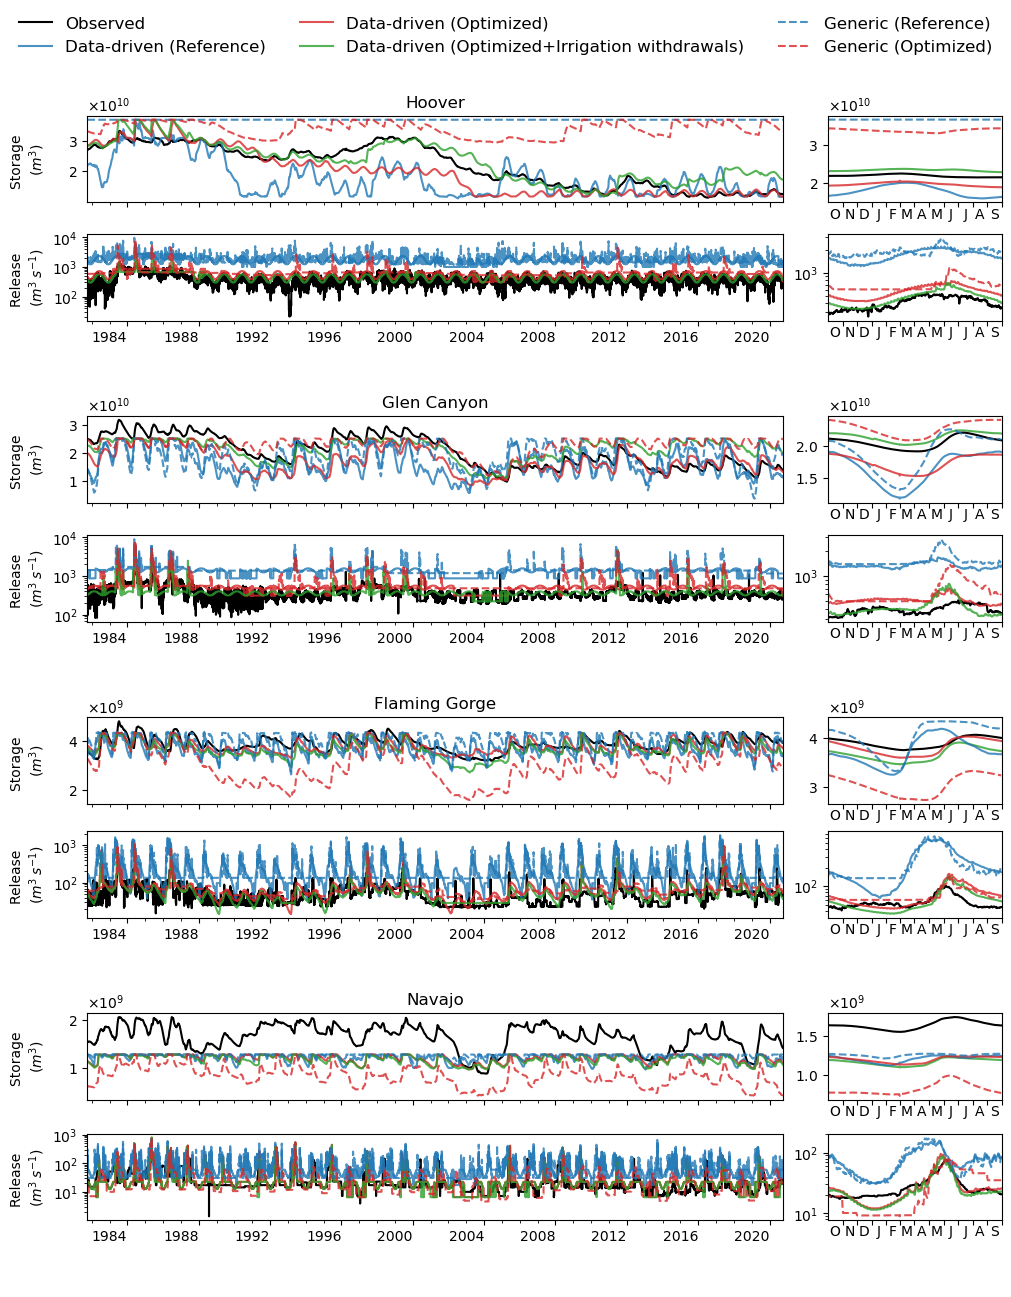

In [76]:
# part 1:
sel_damids = [610,597,451,601]
sel_daminfo = daminfo_obs.loc[sel_damids]

# generic vs empirical
t = np.arange(365)
ti = np.hstack([t[273:],t[:273]])
monthlength = np.array([31,30,31, 31,28,31,30,31,30,31,31,30])

ndam = len(sel_damids)
hr = [1,1,.4]*int(ndam)
wr = [1,.25,1,.25]
fig, axes_all = plt.subplots(int(ndam*3), 2, figsize=(10, int(3*ndam)), layout="constrained",gridspec_kw={'height_ratios':hr[:], 'width_ratios':wr[:2]}, dpi=100)

axes = axes_all
axes1 = axes[::3]
axes2 = axes[1::3]
for ax in axes_all[2::3].ravel():
    ax.axis('off')
for i in range(ndam):
    damid = str(sel_damids[i])
    # storage
    ss = obs_storage_t[damid]*10**6
    ss1 = storage_istarf_ref_nouse[damid]
    ss2 = storage_istarf_opt_nouse[damid]
    ss3 = storage_generic_ref_nouse[damid]
    ss4 = storage_generic_opt_nouse[damid]
    ss2_mod = storage_istarf_optcu[damid]
    
    ax = axes1[i,0]
    ss.plot(ax=ax, c="k", label="Observed")
    ss1.plot(ax=ax, c="tab:blue", alpha=0.8, label="Data-driven (Reference)")
    ss2.plot(ax=ax, c="tab:red", alpha=0.8, label="Data-driven (Optimized)")
    ss2_mod.plot(ax=ax, c="tab:green", alpha=0.8, label="Data-driven (Optimized+Irrigation withdrawals)", zorder=2)
    ss3.plot(ax=ax, c="tab:blue", alpha=0.8, label="Generic (Reference)",ls='--')
    ss4.plot(ax=ax, c="tab:red", alpha=0.8, label="Generic (Optimized)",ls='--')
    # ss2_mod.plot(ax=ax, c="tab:green", alpha=0.8, label="Simulated + Irrigation withdrawals")
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.margins(x=0)
    ax.set_ylabel("Storage \n($m^3$)")
    text = sel_daminfo.loc[sel_damids[i], "Project name"]
    ax.set_title(text, loc="center")
    # ax.grid()
    ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
    ax.set_xticklabels([])
    ax.ticklabel_format(axis='y', useMathText=True)

    ax = axes1[i,1]
    ax.plot(ss.groupby('time.dayofyear').mean().data[ti], c="k", label="Observed")
    ax.plot(ss1.groupby('time.dayofyear').mean().data[ti], c="tab:blue", alpha=0.8, label="Reference",)
    ax.plot(ss2.groupby('time.dayofyear').mean().data[ti], c="tab:red", alpha=0.8, label="Optimized",)
    ax.plot(ss2_mod.groupby('time.dayofyear').mean().data[ti], c="tab:green", alpha=0.8, label="Optimized",zorder=1)
    ax.plot(ss3.groupby('time.dayofyear').mean().data[ti], c="tab:blue", alpha=0.8, label="Reference",ls='--')
    ax.plot(ss4.groupby('time.dayofyear').mean().data[ti], c="tab:red", alpha=0.8, label="Optimized",ls='--')
    
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.margins(x=0)
    ax.ticklabel_format(axis='y', useMathText=True)
    ax.set_xticks(np.cumsum(monthlength))
    ax.set_xticklabels('')
    ax.set_xticks((monthlength*1.0/2.)+np.cumsum(np.append(0,monthlength)[0:12]), minor=True)
    ax.set_xticklabels(['O','N','D', 'J','F','M','A','M','J','J','A','S',], minor=True);
    ax.tick_params('x',which='minor',length=0)

    # release
    rr = obs_release_t[damid]
    rr1 = qmdl_istarf_ref_nouse[damid]
    rr2 = qmdl_istarf_opt_nouse[damid]
    rr2_mod = qmdl_istarf_optcu[damid]
    rr3 = qmdl_generic_ref_nouse[damid]
    rr4 = qmdl_generic_opt_nouse[damid]

    ax = axes2[i,0]
    rr.plot(ax=ax, c="k", label="Observed")
    rr1.plot(ax=ax, c="tab:blue", alpha=0.8, label="Reference")
    rr2.plot(ax=ax, c="tab:red", alpha=0.8, label="Optimized")
    rr2_mod.plot(ax=ax, c="tab:green", alpha=0.8, label="Optimized", zorder=2)
    rr3.plot(ax=ax, c="tab:blue", alpha=0.8, label="Reference",ls='--')
    rr4.plot(ax=ax, c="tab:red", alpha=0.8, label="Optimized",ls='--')
    
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.margins(x=0)
    ax.set_ylabel("Release \n($m^3\;s^{-1}$)")
    text = sel_daminfo.loc[sel_damids[i], "Project name"]
    # ax.grid()
    ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
    ax.tick_params(axis="x",labelrotation=0,)
    ax.ticklabel_format(axis='y', useMathText=True)
    ax.set_yscale('log')
    
    ax = axes2[i,1]
    ax.plot(rr.groupby('time.dayofyear').mean().data[ti], c="k",)
    ax.plot(rr1.groupby('time.dayofyear').mean().data[ti], c="tab:blue", alpha=0.8)
    ax.plot(rr2.groupby('time.dayofyear').mean().data[ti], c="tab:red", alpha=0.8)
    ax.plot(rr2_mod.groupby('time.dayofyear').mean().data[ti], c="tab:green", alpha=0.8, zorder=2)
    ax.plot(rr3.groupby('time.dayofyear').mean().data[ti], c="tab:blue", alpha=0.8,ls='--')
    ax.plot(rr4.groupby('time.dayofyear').mean().data[ti], c="tab:red", alpha=0.8,ls='--')
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.margins(x=0)
    ax.ticklabel_format(axis='y', useMathText=True)
    ax.set_xticks(np.cumsum(monthlength))
    ax.set_xticklabels('')
    ax.set_xticks((monthlength*1.0/2.)+np.cumsum(np.append(0,monthlength)[0:12]), minor=True)
    ax.set_xticklabels(['O','N','D', 'J','F','M','A','M','J','J','A','S',], minor=True);
    ax.tick_params('x',which='minor',length=0)
    ax.set_yscale('log')
    # if i==1: break

fig.align_ylabels(axes_all[:])
fig.legend(*axes[0,0].get_legend_handles_labels(),loc="upper center",bbox_to_anchor=(0.5, 1.075),ncol=3,fontsize=12, frameon=False)

In [77]:
fig.savefig('./figs/dam_sim_timeseries_part1_v1.png', dpi=300, bbox_inches='tight')

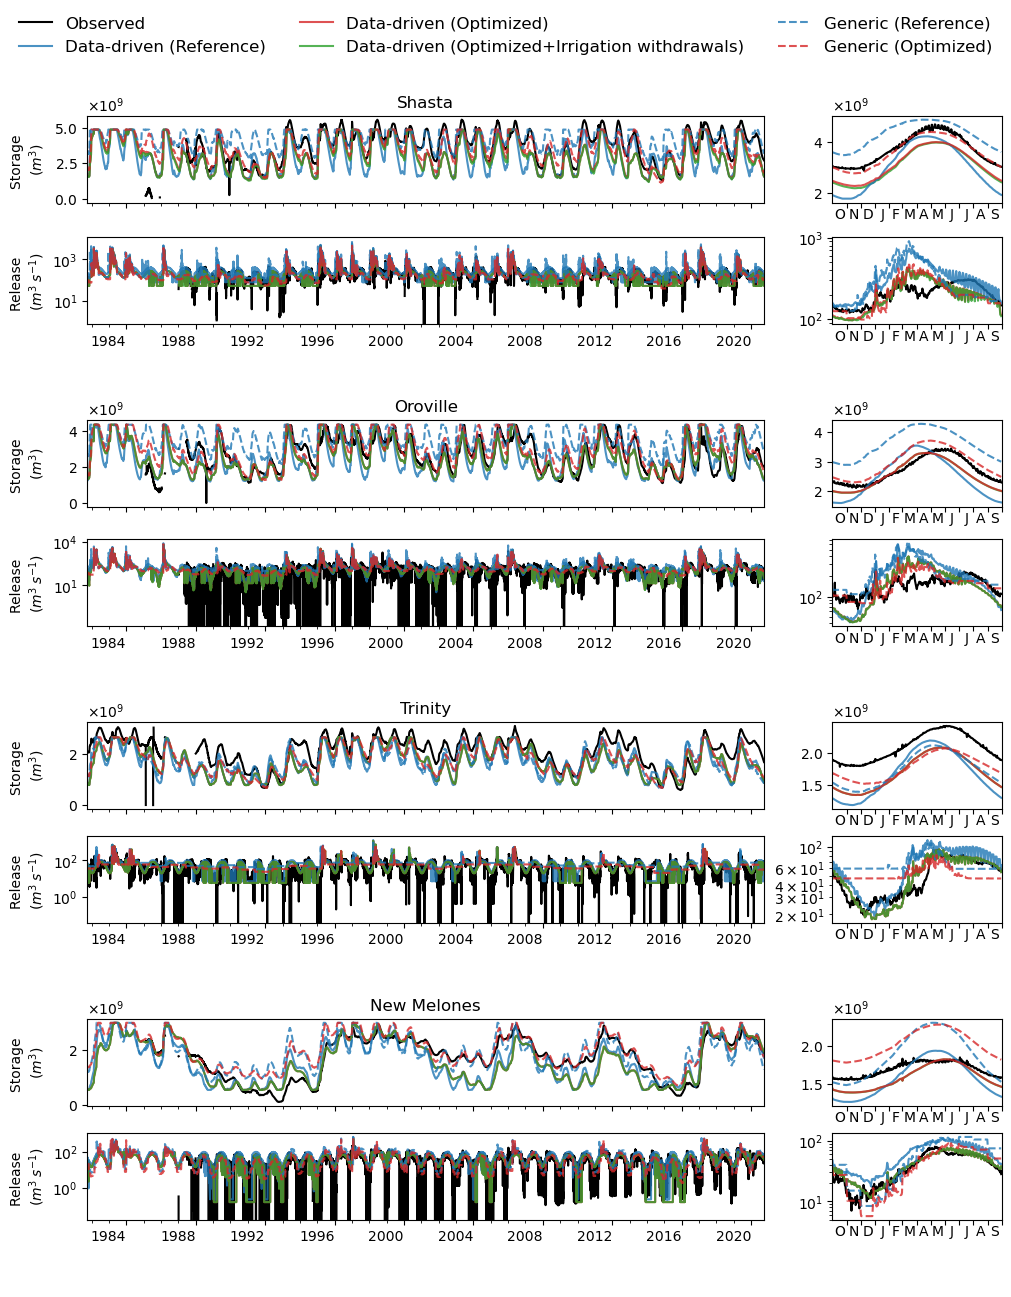

In [78]:
# part 2:
sel_damids = [132,148,131,198]
sel_daminfo = daminfo_obs.loc[sel_damids]

# generic vs empirical
t = np.arange(365)
ti = np.hstack([t[273:],t[:273]])
monthlength = np.array([31,30,31, 31,28,31,30,31,30,31,31,30])

ndam = len(sel_damids)
hr = [1,1,.4]*int(ndam)
wr = [1,.25,1,.25]
fig, axes_all = plt.subplots(int(ndam*3), 2, figsize=(10, int(3*ndam)), layout="constrained",gridspec_kw={'height_ratios':hr[:], 'width_ratios':wr[:2]}, dpi=100)

axes = axes_all
axes1 = axes[::3]
axes2 = axes[1::3]
for ax in axes_all[2::3].ravel():
    ax.axis('off')
for i in range(ndam):
    damid = str(sel_damids[i])
    # storage
    ss = obs_storage_t[damid]*10**6
    ss1 = storage_istarf_ref_nouse[damid]
    ss2 = storage_istarf_opt_nouse[damid]
    ss3 = storage_generic_ref_nouse[damid]
    ss4 = storage_generic_opt_nouse[damid]
    ss2_mod = storage_istarf_optcu[damid]
    
    ax = axes1[i,0]
    ss.plot(ax=ax, c="k", label="Observed")
    ss1.plot(ax=ax, c="tab:blue", alpha=0.8, label="Data-driven (Reference)")
    ss2.plot(ax=ax, c="tab:red", alpha=0.8, label="Data-driven (Optimized)")
    ss2_mod.plot(ax=ax, c="tab:green", alpha=0.8, label="Data-driven (Optimized+Irrigation withdrawals)", zorder=2)
    ss3.plot(ax=ax, c="tab:blue", alpha=0.8, label="Generic (Reference)",ls='--')
    ss4.plot(ax=ax, c="tab:red", alpha=0.8, label="Generic (Optimized)",ls='--')
    # ss2_mod.plot(ax=ax, c="tab:green", alpha=0.8, label="Simulated + Irrigation withdrawals")
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.margins(x=0)
    ax.set_ylabel("Storage \n($m^3$)")
    text = sel_daminfo.loc[sel_damids[i], "Project name"]
    ax.set_title(text, loc="center")
    # ax.grid()
    ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
    ax.set_xticklabels([])
    ax.ticklabel_format(axis='y', useMathText=True)

    ax = axes1[i,1]
    ax.plot(ss.groupby('time.dayofyear').mean().data[ti], c="k", label="Observed")
    ax.plot(ss1.groupby('time.dayofyear').mean().data[ti], c="tab:blue", alpha=0.8, label="Reference",)
    ax.plot(ss2.groupby('time.dayofyear').mean().data[ti], c="tab:red", alpha=0.8, label="Optimized",)
    ax.plot(ss2_mod.groupby('time.dayofyear').mean().data[ti], c="tab:green", alpha=0.8, label="Optimized",zorder=1)
    ax.plot(ss3.groupby('time.dayofyear').mean().data[ti], c="tab:blue", alpha=0.8, label="Reference",ls='--')
    ax.plot(ss4.groupby('time.dayofyear').mean().data[ti], c="tab:red", alpha=0.8, label="Optimized",ls='--')
    
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.margins(x=0)
    ax.ticklabel_format(axis='y', useMathText=True)
    ax.set_xticks(np.cumsum(monthlength))
    ax.set_xticklabels('')
    ax.set_xticks((monthlength*1.0/2.)+np.cumsum(np.append(0,monthlength)[0:12]), minor=True)
    ax.set_xticklabels(['O','N','D', 'J','F','M','A','M','J','J','A','S',], minor=True);
    ax.tick_params('x',which='minor',length=0)

    # release
    rr = obs_release_t[damid]
    rr1 = qmdl_istarf_ref_nouse[damid]
    rr2 = qmdl_istarf_opt_nouse[damid]
    rr2_mod = qmdl_istarf_optcu[damid]
    rr3 = qmdl_generic_ref_nouse[damid]
    rr4 = qmdl_generic_opt_nouse[damid]

    ax = axes2[i,0]
    rr.plot(ax=ax, c="k", label="Observed")
    rr1.plot(ax=ax, c="tab:blue", alpha=0.8, label="Reference")
    rr2.plot(ax=ax, c="tab:red", alpha=0.8, label="Optimized")
    rr2_mod.plot(ax=ax, c="tab:green", alpha=0.8, label="Optimized", zorder=2)
    rr3.plot(ax=ax, c="tab:blue", alpha=0.8, label="Reference",ls='--')
    rr4.plot(ax=ax, c="tab:red", alpha=0.8, label="Optimized",ls='--')
    
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.margins(x=0)
    ax.set_ylabel("Release \n($m^3\;s^{-1}$)")
    text = sel_daminfo.loc[sel_damids[i], "Project name"]
    # ax.grid()
    ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
    ax.tick_params(axis="x",labelrotation=0,)
    ax.ticklabel_format(axis='y', useMathText=True)
    ax.set_yscale('log')
    
    ax = axes2[i,1]
    ax.plot(rr.groupby('time.dayofyear').mean().data[ti], c="k",)
    ax.plot(rr1.groupby('time.dayofyear').mean().data[ti], c="tab:blue", alpha=0.8)
    ax.plot(rr2.groupby('time.dayofyear').mean().data[ti], c="tab:red", alpha=0.8)
    ax.plot(rr2_mod.groupby('time.dayofyear').mean().data[ti], c="tab:green", alpha=0.8, zorder=2)
    ax.plot(rr3.groupby('time.dayofyear').mean().data[ti], c="tab:blue", alpha=0.8,ls='--')
    ax.plot(rr4.groupby('time.dayofyear').mean().data[ti], c="tab:red", alpha=0.8,ls='--')
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.margins(x=0)
    ax.ticklabel_format(axis='y', useMathText=True)
    ax.set_xticks(np.cumsum(monthlength))
    ax.set_xticklabels('')
    ax.set_xticks((monthlength*1.0/2.)+np.cumsum(np.append(0,monthlength)[0:12]), minor=True)
    ax.set_xticklabels(['O','N','D', 'J','F','M','A','M','J','J','A','S',], minor=True);
    ax.tick_params('x',which='minor',length=0)
    ax.set_yscale('log')
    # if i==1: break

fig.align_ylabels(axes_all[:])
fig.legend(*axes[0,0].get_legend_handles_labels(),loc="upper center",bbox_to_anchor=(0.5, 1.075),ncol=3,fontsize=12, frameon=False)

In [79]:
fig.savefig('./figs/dam_sim_timeseries_part2_v1.png', dpi=300, bbox_inches='tight')